# Instalaciones necesarias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow

In [ ]:
!pip install --quiet optuna

In [ ]:
pip install shap

In [ ]:
from IPython.display import display
import shap
shap.initjs()

# Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelBinarizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV,GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from keras.layers import Conv2D
from keras.optimizers import SGD
from keras import backend as K
from scipy.stats import randint
import joblib
import optuna
import shap

import warnings
warnings.filterwarnings("ignore")

# Carga de dataset

In [ ]:
file_path= '/content/drive/MyDrive/weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Transformación y limpieza de los datos

In [ ]:
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [ ]:
#Filtramos el DataFrame para incluir solo las ciudades de la costa sureste

ciudades_a_filtrar = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades_a_filtrar)]

In [ ]:
#Eliminamos los registros vacíos en las columnas a predecir

columnas_a_borrar = ['RainToday', 'RainTomorrow', 'RainfallTomorrow']
df = df.dropna(subset=columnas_a_borrar)

In [ ]:
#Transformamos la variable 'Date' para categorizarla por mes
df['Date'] = pd.to_datetime(df['Date'])
df['Mes'] = df['Date'].dt.month

In [ ]:
#Eliminamos columnas innecesarias

columnas_a_eliminar = ['Unnamed: 0', 'Date', 'Location']
df.drop(columnas_a_eliminar, axis=1, inplace=True)

In [ ]:
#Verificamos de que tipo es cada variable y la cantidad de datos nulos que posee

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 30167 to 70370
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           15028 non-null  float64
 1   MaxTemp           15031 non-null  float64
 2   Rainfall          15036 non-null  float64
 3   Evaporation       13355 non-null  float64
 4   Sunshine          13105 non-null  float64
 5   WindGustDir       13600 non-null  object 
 6   WindGustSpeed     13602 non-null  float64
 7   WindDir9am        14364 non-null  object 
 8   WindDir3pm        14748 non-null  object 
 9   WindSpeed9am      14776 non-null  float64
 10  WindSpeed3pm      14787 non-null  float64
 11  Humidity9am       14950 non-null  float64
 12  Humidity3pm       14993 non-null  float64
 13  Pressure9am       14784 non-null  float64
 14  Pressure3pm       14792 non-null  float64
 15  Cloud9am          13136 non-null  float64
 16  Cloud3pm          12900 non-null  fl

# Análisis exploratorio de los datos

In [ ]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow,Mes
count,15028.000000,15031.000000,15036.000000,13355.000000,13105.000000,13602.000000,14776.000000,14787.000000,14950.000000,14993.000000,14784.000000,14792.000000,13136.000000,12900.000000,15014.000000,15022.000000,15036.000000,15036.000000
mean,11.612610,21.803739,2.299601,4.881041,6.907707,44.290619,16.443760,21.731589,68.876388,51.239645,1018.338400,1016.077778,4.737972,4.735349,15.588770,20.277899,2.250213,6.443669
std,5.886335,6.058224,7.404618,3.056038,3.837245,14.948251,10.264783,9.525705,15.653725,17.757028,7.400836,7.265255,2.731119,2.593540,5.572921,5.861972,7.318972,3.424935
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,1.000000
25%,7.900000,17.200000,0.000000,2.600000,3.800000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,16.000000,0.000000,3.000000
50%,11.600000,21.300000,0.000000,4.200000,7.600000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.500000,19.800000,0.000000,6.000000
75%,15.900000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.600000,24.200000,0.800000,9.000000
max,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,119.400000,12.000000


##Correlacion de las variables:
Nuestra variable numerica a predecir "RainfallTomorrow" posee mayor correlacion con "Humidity3pm", "Rainfall", "Cloud3pm" y "Sunshine"


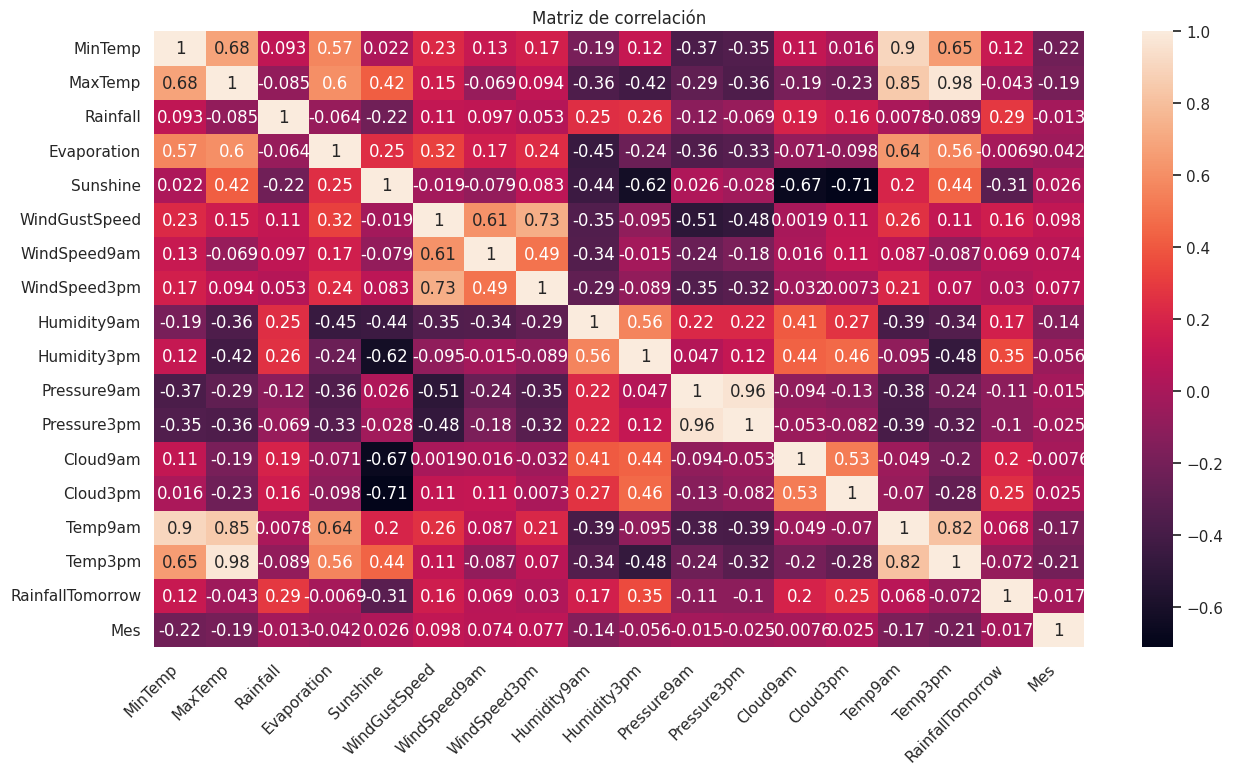

In [ ]:
#Se realiza y se grafica la matriz de correlación para analizar las relaciones entre las variables

matriz_corr = df.corr()

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(matriz_corr, annot=True)
plt.xticks(rotation=45, ha='right')
plt.title('Matriz de correlación')
plt.show()

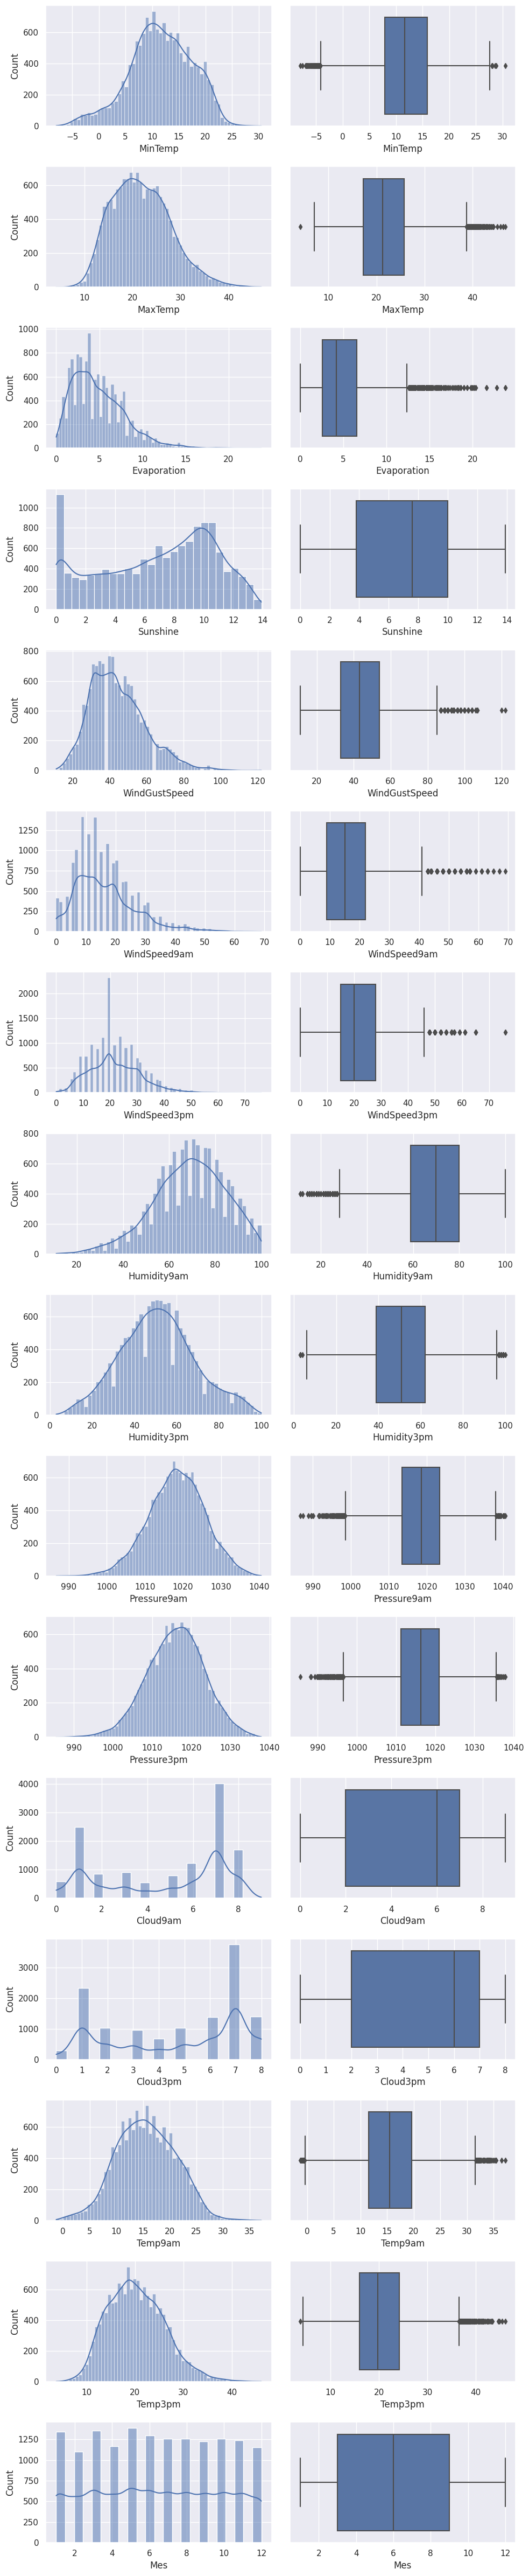

In [ ]:
#Creamos histogramas y diagramas de cajas por cada variable numérica

columnas_numericas = df.select_dtypes(include=['number'])
columnas_a_eliminar = ['Rainfall', 'RainfallTomorrow']
columnas_numericas = columnas_numericas.drop(columns=columnas_a_eliminar)

fig, axes = plt.subplots(nrows=len(columnas_numericas.columns), ncols=2, figsize=(10, 3 * len(columnas_numericas.columns)))

for i, columna in enumerate(columnas_numericas.columns):
    sns.histplot(df[columna], ax=axes[i, 0], kde=True)
    sns.boxplot(data=df, x=columna, ax=axes[i, 1])

plt.tight_layout()
plt.show()

Graficamos las distribuciones de las variables:
MinTemp y MaxTemp poseen distribucion asimetrica
Evaporation posee una distribucion asimetrica a la derecha
Humidity9am pareciera que posee una distribucion asimetrica a la izquierda

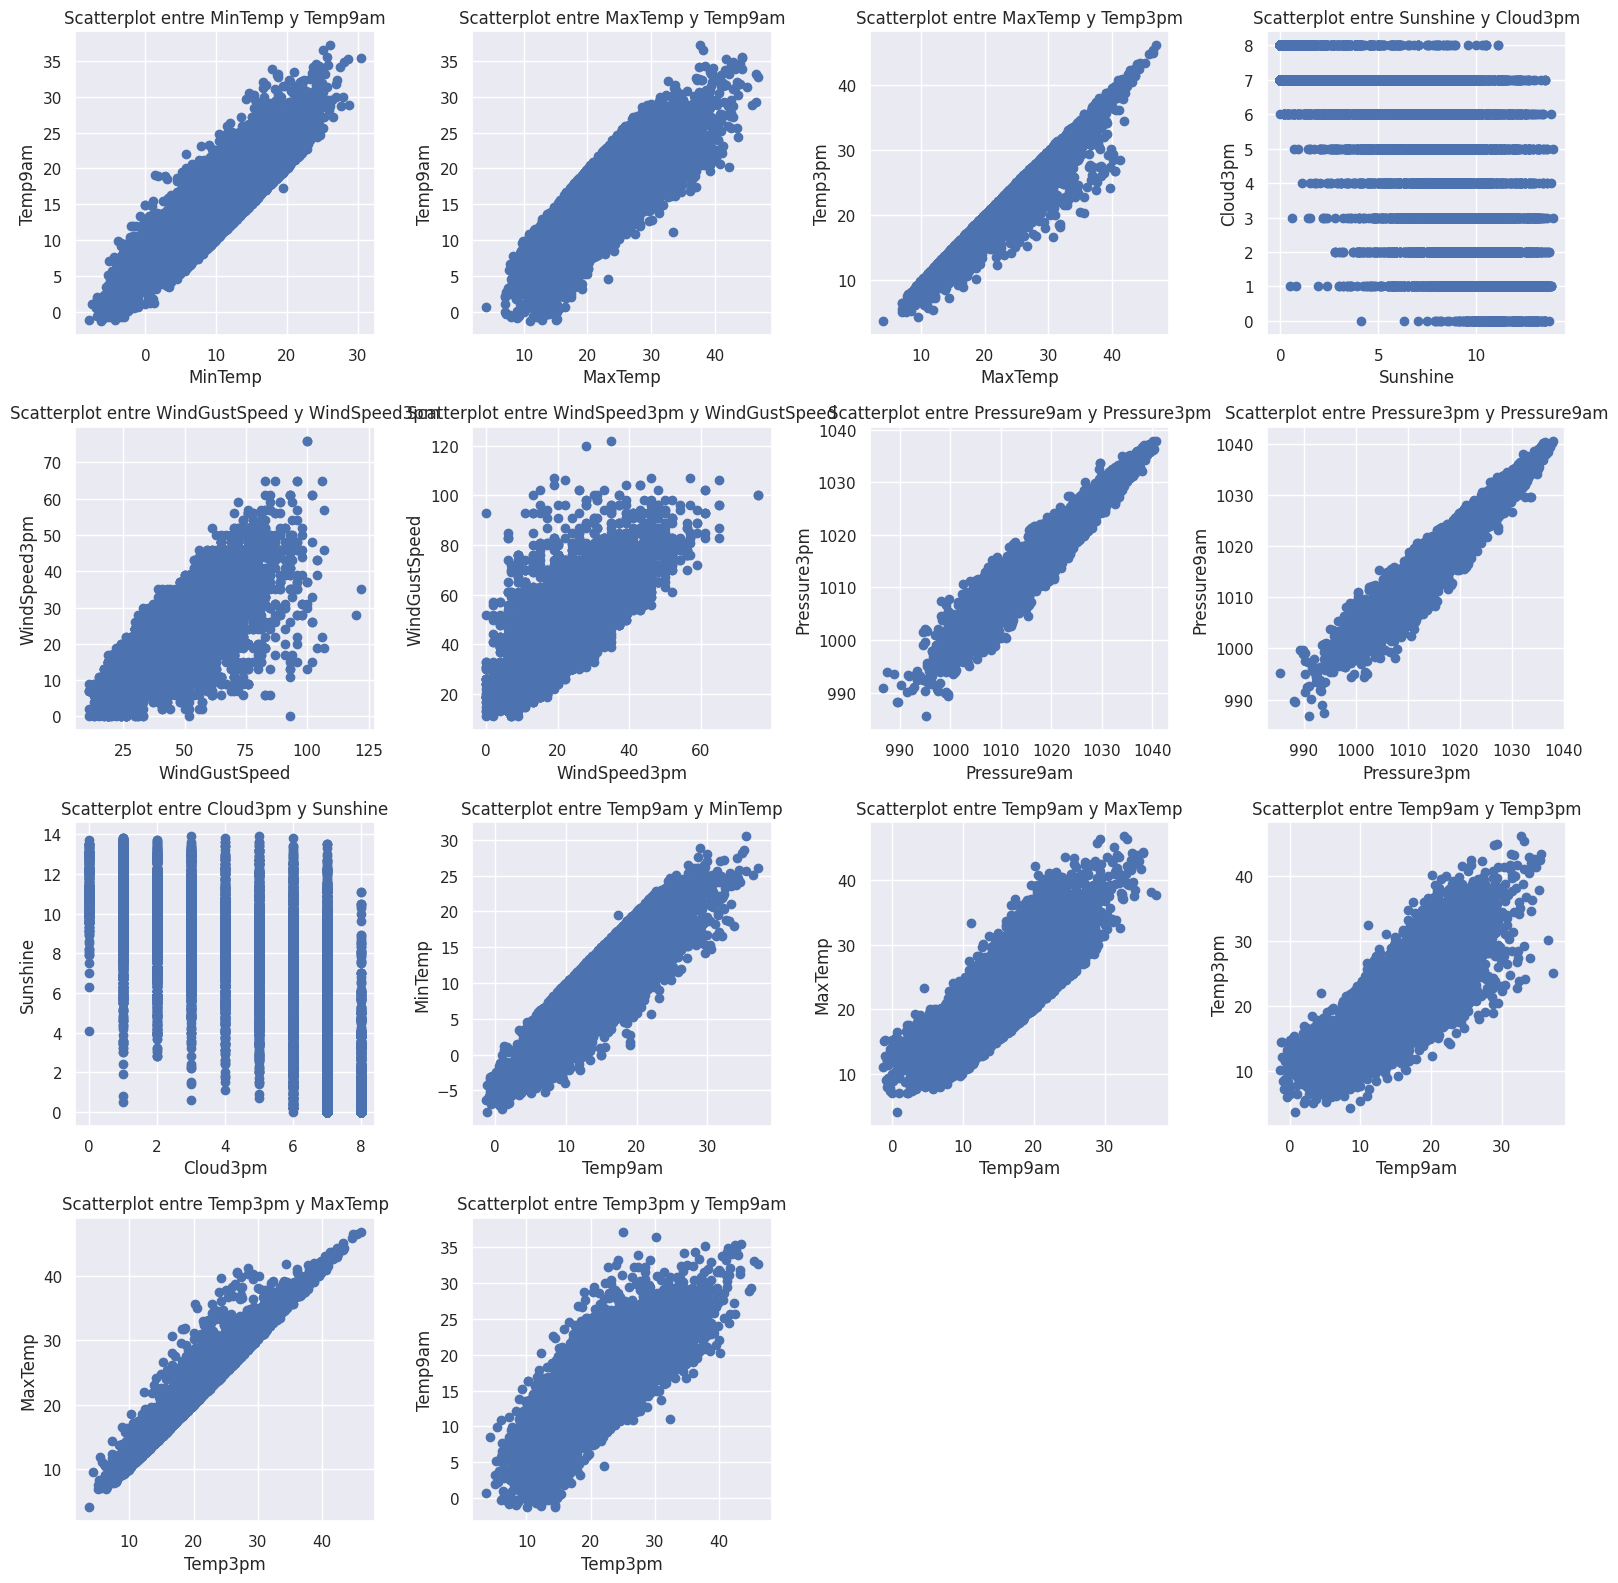

In [ ]:
#Creamos scatterplots entre las variables más fuertemente relacionadas

mascara = (matriz_corr > 0.7) | (matriz_corr < -0.7)

variables_seleccionadas = []
for var1 in matriz_corr.columns:
    for var2 in matriz_corr.columns:
        if var1 != var2 and mascara.loc[var1, var2]:
            variables_seleccionadas.append((var1, var2))

graficos_por_fila = 4
num_filas = len(variables_seleccionadas) // graficos_por_fila + 1
plt.figure(figsize=(16, 4 * num_filas))

for i, (var1, var2) in enumerate(variables_seleccionadas):
    plt.subplot(num_filas, graficos_por_fila, i + 1)
    plt.scatter(df[var1], df[var2])
    plt.title(f'Scatterplot entre {var1} y {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.tight_layout()

plt.show()

Graficamos las variables que possen una relacion mayor a 0,70 (MinTemp y Temp9am) y las que tienen una menor a -0,70 (Sunshine y Cloud3pm)

# División del dataset

In [ ]:
# Dividimos el dataset asignando las etiquetas según regresión o clasificación
X = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']
y_clas = df['RainTomorrow']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

X_train_clas, X_test_clas, y_train_clas, y_test_clas = train_test_split(X, y_clas, test_size=0.2, random_state=42)

# Imputación de datos faltantes

In [ ]:
#Rellenamos los valores faltantes con la media en las columnas numéricas
medias = X_train_reg.mean()
X_train_reg = X_train_reg.fillna(medias)

medias = X_train_clas.mean()
X_train_clas = X_train_clas.fillna(medias)

medias = y_train_reg.mean()
y_train_reg = y_train_reg.fillna(medias)

medias = X_test_reg.mean()
X_test_reg = X_test_reg.fillna(medias)

medias = X_test_clas.mean()
X_test_clas = X_test_clas.fillna(medias)

In [ ]:
#Rellenamos los valores faltantes con la moda en las columnas no numéricas
modas = X_train_reg.mode().iloc[0]
X_train_reg = X_train_reg.fillna(modas)

modas = X_train_clas.mode().iloc[0]
X_train_clas = X_train_clas.fillna(modas)

modas = y_train_clas.mode().iloc[0]
y_train_clas = y_train_clas.fillna(modas)

modas = X_test_reg.mode().iloc[0]
X_test_reg = X_test_reg.fillna(modas)

modas = X_test_clas.mode().iloc[0]
X_test_clas = X_test_clas.fillna(modas)

# Codificación de variables categóricas

In [ ]:
#Utilizamos la función get_dummies de Pandas para aplicar One-Hot Encoding a las variables categóricas
X_train_reg = pd.get_dummies(X_train_reg, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'],
                            prefix=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'])

X_train_clas = pd.get_dummies(X_train_clas, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'],
                            prefix=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'])

X_test_reg = pd.get_dummies(X_test_reg, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'],
                            prefix=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'])

X_test_clas = pd.get_dummies(X_test_clas, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'],
                            prefix=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Mes'])

In [ ]:
#Mapeamos los valores de las variables 'RainToday' y 'RainTomorrow'
X_train_reg['RainToday'] = X_train_reg['RainToday'].map({'Yes': 1, 'No': 0})
X_train_clas['RainToday'] = X_train_clas['RainToday'].map({'Yes': 1, 'No': 0})
y_train_clas = y_train_clas.map({'Yes': 1, 'No': 0})
X_test_reg['RainToday'] = X_test_reg['RainToday'].map({'Yes': 1, 'No': 0})
X_test_clas['RainToday'] = X_test_clas['RainToday'].map({'Yes': 1, 'No': 0})
y_test_clas = y_test_clas.map({'Yes': 1, 'No': 0})

In [ ]:
# Creamos una copia para MLOps
X_mlops_reg = X_train_reg
y_mlops_reg = y_train_reg
X_mlops_clas = X_train_clas
y_mlops_clas = y_train_clas

# ¿Está balanceado el dataset?

In [ ]:
#Calculamos la frecuencia y la proporción de ejemplos en cada clase
conteo_clases = df['RainToday'].value_counts()
proporcion_clases = conteo_clases / len(df)

print("Conteo de Clases:")
print(conteo_clases)
print("\nProporción de Clases:")
print(proporcion_clases)

Conteo de Clases:
No     11541
Yes     3495
Name: RainToday, dtype: int64

Proporción de Clases:
No     0.767558
Yes    0.232442
Name: RainToday, dtype: float64


Ya que la proporción de ambos valores es claramente muy dispar, se puede decir que el dataset no está balanceado.
Por ese motivo procedemos a balancear los datos de entrenamiento.

In [ ]:
# Aplicamos RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_clas, y_train_clas = undersampler.fit_resample(X_train_clas, y_train_clas)

In [ ]:
# Creamos una copia de los datos de entrenamiento para un uso posterior
X_shap_reg = X_train_reg
X_shap_clas = X_train_clas

# Estandarización de variables

In [ ]:
# Utilizamos el método StandardScaler de Scikit-Learn para estandarizar las variables
scaler = StandardScaler()

# Ajustar el scaler en el conjunto de entrenamiento y transformar tanto el conjunto de entrenamiento como el de prueba
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)
X_train_clas = scaler.fit_transform(X_train_clas)
X_test_clas = scaler.transform(X_test_clas)

# Selección de características para la predicción

### PCA

Criterios de selección:

    Proporción de variancia acumulada (~75% -80%)​
    Criterio de Kaiser (eigenvalues > 1)​
    Gráfico del codo (Scree)

In [ ]:
pca = PCA()
pca.fit(X_train_reg)

PCA()

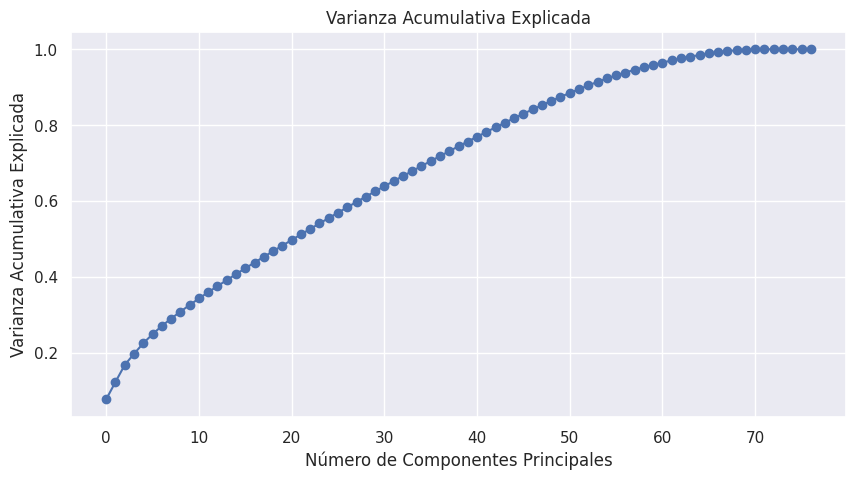

In [ ]:
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

#Creamos un gráfico de la varianza explicada acumulativa
plt.figure(figsize=(10, 5))
plt.plot(explained_variance_ratio_cumulative, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulativa Explicada')
plt.title('Varianza Acumulativa Explicada')
plt.grid(True)
plt.show()

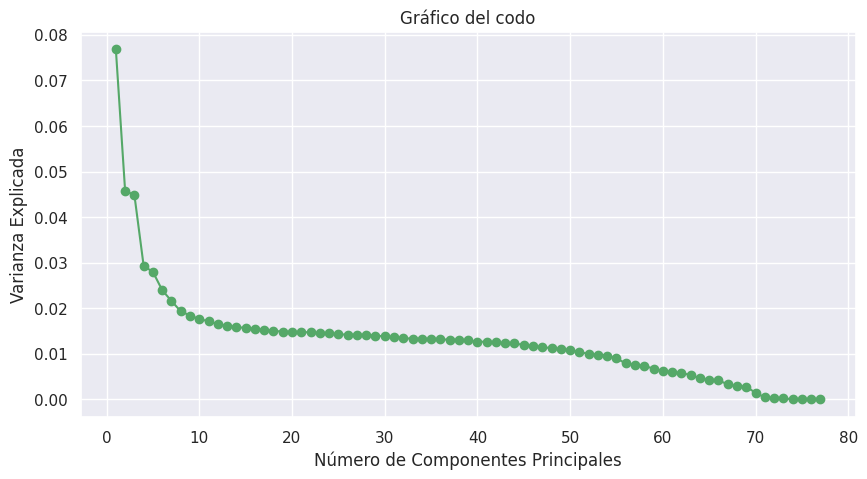

In [ ]:
#Creamos el gráfico del codo
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-', color='g')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Gráfico del codo')
plt.grid(True)
plt.show()

In [ ]:
#Obtenemos los autovalores de las componentes para analizar el criterio de Kaiser
eigenvalues = pca.explained_variance_

components_to_keep = sum(eigenvalues > 1)

print(f"Número de componentes que cumplen con el criterio de Kaiser: {components_to_keep}")


Número de componentes que cumplen con el criterio de Kaiser: 38


Con las métricas calculadas podemos ver que los principales componentes que explican el fenómeno son entre 5 y 10.

In [ ]:
#Creamos un nuevo DataFrame con las componentes principales

n_components = 5
X_pca_top = pca.transform(X_test_reg)[:, :n_components]

pca_df_top = pd.DataFrame(data=X_pca_top, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df_top

,PC1,PC2,PC3,PC4,PC5
0,5.187391,1.332349,3.351764,-2.599123,-1.120060
1,1.767530,-1.092841,0.872730,0.211100,-0.988159
2,1.807718,2.244420,-1.529486,-0.988533,0.623234
3,3.904809,-2.956760,0.547820,0.311732,0.080675
4,-2.521458,0.217798,0.486166,2.362041,1.176331
...,...,...,...,...,...
3003,-3.537657,2.181167,3.408245,0.461119,3.201560
3004,-3.278552,-3.073717,-1.139853,-0.524249,0.588391
3005,-5.159882,0.627451,-1.769174,0.780694,0.179346
3006,1.522927,-2.690066,-3.584704,0.503595,-0.048266


#Modelo Base de Regresión Lineal

In [ ]:
# Definimos la función MAPE
def mape(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Añadimos una pequeña constante para evitar divisiones por cero
    y_true = y_true + epsilon

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Calcula la media de 'y_train'
mean_value = y_train_reg.mean()

# Crear un modelo de regresión lineal que siempre predice la media
model_base = LinearRegression()
model_base.fit(X_train_reg, [mean_value] * len(X_train_reg))

# Realiza predicciones
y_pred_base = model_base.predict(X_test_reg)

# Mostrar resultados
print(f'Media real: {y_test_reg.mean()}')
print(f'Media predicha: {mean_value}')

# Métricas
r2_base = r2_score(y_test_reg, y_pred_base)
mse_base = mean_squared_error(y_test_reg, y_pred_base)
rmse_base = np.sqrt(mse_base)
mae_base = mean_absolute_error(y_test_reg, y_pred_base)
mape_base = mape(y_test_reg, y_pred_base)

print(f"R2 Score: {r2_base}")
print(f"MSE: {mse_base}")
print(f"RMSE: {rmse_base}")
print(f"MAE: {mae_base}")
print(f"MAPE: {mape_base}%")

Media real: 2.5620678191489366
Media predicha: 2.1722231459926835
R2 Score: -0.0022168414569490036
MSE: 68.70846887522717
RMSE: 8.289057176496442
MAE: 3.6578943347614423
MAPE: 1395913344838.15%


# Regresión Lineal


In [ ]:
#Utilizamos el método de regresión lineal y calculamos las métricas
model_rl = LinearRegression()

model_rl.fit(X_train_reg, y_train_reg)

y_pred = model_rl.predict(X_test_reg)

r2_lr = r2_score(y_test_reg, y_pred)
mse_lr = mean_squared_error(y_test_reg, y_pred)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test_reg, y_pred)
mape_lr = mape(y_test_reg, y_pred)

print(f"R2 Score: {r2_lr}")
print(f"MSE: {mse_lr}")
print(f"RMSE: {rmse_lr}")
print(f"MAE: {mae_lr}")
print(f"MAPE: {mape_lr}%")

R2 Score: 0.22897485301066867
MSE: 52.85877778397874
RMSE: 7.270404238003464
MAE: 3.321939048671899
MAPE: 1153564423877.5962%


In [ ]:
# Predicciones para el conjunto de prueba
y_pred = model_rl.predict(X_test_reg)

# Mostrar las predicciones
predictions = pd.DataFrame({'Actual': y_test_reg, 'Predicted': y_pred})
print(predictions.head())

       Actual  Predicted
67749     0.0   1.895511
67272     0.0   2.256840
45636     0.0   5.568363
35170     0.0  -0.144528
66900     0.0   1.743168


# Gradiente Descendiente

In [ ]:
##Utilizamos el método de gradiente descendiente y calculamos las métricas
model_gd = SGDRegressor(max_iter=10000, alpha=0.01, learning_rate='constant', eta0=0.01, random_state=42)

model_gd.fit(X_train_reg, y_train_reg)

y_pred = model_gd.predict(X_test_reg)

r2_gd = r2_score(y_test_reg, y_pred)
mse_gd = mean_squared_error(y_test_reg, y_pred)
rmse_gd = np.sqrt(mse_gd)
mae_gd = mean_absolute_error(y_test_reg, y_pred)
mape_gd = mape(y_test_reg, y_pred)

print(f"R2 Score: {r2_gd}")
print(f"MSE: {mse_gd}")
print(f"RMSE: {rmse_gd}")
print(f"MAE: {mae_gd}")
print(f"MAPE: {mape_gd}%")

R2 Score: -0.0017060342678891782
MSE: 68.67344972727537
RMSE: 8.286944535066912
MAE: 4.167667123480375
MAPE: 1711841192924.2139%


# Metodos de Regularizacion

## Lasso

In [ ]:
#Utilizamos el método Lasso y calculamos las métricas
lasso_model = LassoCV()

lasso_model.fit(X_train_reg, y_train_reg)

y_pred_lasso = lasso_model.predict(X_test_reg)

r2_lasso = r2_score(y_test_reg, y_pred_lasso)
mse_lasso = mean_squared_error(y_test_reg, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test_reg, y_pred_lasso)
mape_lasso = mape(y_test_reg, y_pred_lasso)

print(f"R2 Score: {r2_lasso}")
print(f"MSE: {mse_lasso}")
print(f"RMSE: {rmse_lasso}")
print(f"MAE: {mae_lasso}")
print(f"MAPE: {mape_lasso}%")

R2 Score: 0.2286418620725038
MSE: 52.88160647390315
RMSE: 7.271974042438762
MAE: 3.2994173702891167
MAPE: 1134666417138.021%


##Ridge

In [ ]:
#Utilizamos el método Ridge y calculamos las métricas

ridge_model = RidgeCV()

ridge_model.fit(X_train_reg, y_train_reg)

y_pred_ridge = ridge_model.predict(X_test_reg)

r2_ridge = r2_score(y_test_reg, y_pred_ridge)
mse_ridge = mean_squared_error(y_test_reg, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test_reg, y_pred_ridge)
mape_ridge = mape(y_test_reg, y_pred_ridge)

print(f"R2 Score: {r2_ridge}")
print(f"MSE: {mse_ridge}")
print(f"RMSE: {rmse_ridge}")
print(f"MAE: {mae_ridge}")
print(f"MAPE: {mape_ridge}%")

R2 Score: 0.22880470917019025
MSE: 52.87044224847809
RMSE: 7.271206381920272
MAE: 3.3195867608114713
MAPE: 1151287572787.5972%


## Elasticnet

In [ ]:
#Utilizamos el método ElasticNet y calculamos las métricas
elasticnet_model = ElasticNetCV()

elasticnet_model.fit(X_train_reg, y_train_reg)

y_pred_elasticnet = elasticnet_model.predict(X_test_reg)

r2_elasticnet = r2_score(y_test_reg, y_pred_elasticnet)
mse_elasticnet = mean_squared_error(y_test_reg, y_pred_elasticnet)
rmse_elasticnet = np.sqrt(mse_elasticnet)
mae_elasticnet = mean_absolute_error(y_test_reg, y_pred_elasticnet)
mape_elasticnet = mape(y_test_reg, y_pred_elasticnet)

print(f"R2 Score: {r2_elasticnet}")
print(f"MSE: {mse_elasticnet}")
print(f"RMSE: {rmse_elasticnet}")
print(f"MAE: {mae_elasticnet}")
print(f"MAPE: {mape_elasticnet}%")

R2 Score: 0.22841396594470564
MSE: 52.89723023251096
RMSE: 7.2730482077675624
MAE: 3.3093609679719753
MAPE: 1142111776647.8057%


# Modelo Base de Regresión Logística

In [ ]:
# Calcula la media de la variable objetivo en el conjunto de entrenamiento
media_y = np.mean(y_train_clas)

# Crea un array con la misma longitud que y_test_clas y llena con la media calculada
y_pred_base = np.full_like(y_test_clas, fill_value=media_y, dtype=np.float64)

# Redondea las predicciones a la clase más cercana (0 o 1)
y_pred_base = np.round(y_pred_base)

# Imprime las predicciones
print("Predicciones del Modelo Base:")
print(y_pred_base)

# Evalúa el modelo base y muestra la precisión
accuracy_base = accuracy_score(y_test_clas, y_pred_base)
print("\nPrecisión del Modelo Base:", accuracy_base)

Predicciones del Modelo Base:
[0. 0. 0. ... 0. 0. 0.]

Precisión del Modelo Base: 0.7629654255319149


# Regresión Logística


In [ ]:
# Crea y entrena el modelo de Regresión Logística
model_log = LogisticRegression().fit(X_train_clas, y_train_clas)
np.set_printoptions(suppress=True)

# Realiza predicciones en el conjunto de prueba
y_pred_clas = model_log.predict(X_test_clas)

# Imprime las predicciones y las probabilidades
print("Predicciones:")
print(y_pred_clas)
print("\nProbabilidades de Clase:")
print(model_log.predict_proba(X_test_clas))

# Evalúa el modelo y muestra la precisión
accuracy = model_log.score(X_test_clas, y_test_clas)
print("\nPrecisión del Modelo:", accuracy)

# Muestra los coeficientes e intercepto del modelo
print("\nIntercepto:", model_log.intercept_)
print("Coeficientes de Características:", model_log.coef_)


Predicciones:
[1 0 1 ... 0 0 0]

Probabilidades de Clase:
[[0.45318017 0.54681983]
 [0.65497191 0.34502809]
 [0.2792595  0.7207405 ]
 ...
 [0.57898758 0.42101242]
 [0.77249005 0.22750995]
 [0.75707836 0.24292164]]

Precisión del Modelo: 0.7822473404255319

Intercepto: [0.07496406]
Coeficientes de Características: [[-0.44931492 -0.16019461  0.19504601 -0.0310018  -0.59878114  0.52859706
  -0.02925017 -0.0860044   0.12293498  1.08019646  0.87350933 -1.33521712
  -0.11591294  0.30380349  0.53312586  0.48748079  0.18001276  0.0394457
  -0.09566954  0.13475642 -0.03694079 -0.07878119 -0.00104907 -0.00217988
   0.00242199 -0.03643669  0.01731112  0.05884497  0.0239978   0.03808205
   0.0110718  -0.03965039  0.01905726  0.10643041  0.04971179 -0.01400591
  -0.0201643   0.06131455  0.00657407 -0.01857139 -0.05116021 -0.0950492
   0.03493381 -0.01195306  0.00601908 -0.03507424  0.06453021 -0.02345535
   0.01528036 -0.07663205 -0.1075109   0.04334846 -0.05824748 -0.09998804
  -0.04845863  0.0468

## Métricas Clasificación

### ACCURACY

Accuracy (Precisión): El Accuracy se refiere a la precisión general del modelo, es decir, la proporción de predicciones correctas en relación con el total de predicciones. El modelo tiene una precisión del 78%. Esto significa que el 78% de las predicciones del modelo son correctas.

In [ ]:
accuracy = accuracy_score(y_test_clas, y_pred_clas)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.78


### PRECISION

Precision (Precisión): La Precision mide la capacidad del modelo para predecir correctamente los verdaderos positivos en relación con todas las predicciones positivas. El modelo tiene una precisión del 53%. Esto significa que el 53% de las predicciones positivas del modelo son verdaderos positivos.

In [ ]:
precision = precision_score(y_test_clas, y_pred_clas, pos_label=1)
print(f'Precision: {precision:.2f}')

Precision: 0.53


### RECALL

Recall (Recuperación): El Recall mide la capacidad del modelo para capturar todos los verdaderos positivos en relación con todos los ejemplos positivos en los datos reales. El modelo tiene un recall del 78%. Esto significa que el modelo identifica correctamente el 78% de los casos positivos en los datos reales.

In [ ]:
recall = recall_score(y_test_clas, y_pred_clas, pos_label=1)
print(f'Recall: {recall:.2f}')

Recall: 0.78


### F1 SCORE

F1 Score: El F1 Score es una métrica que combina la precisión y el recall en una sola puntuación. Es útil cuando deseas encontrar un equilibrio entre la precisión y la capacidad del modelo para capturar casos positivos. El modelo tiene un F1 Score del 63%.

In [ ]:
f1 = f1_score(y_test_clas, y_pred_clas, pos_label=1)
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.63


### ROC-AUC

ROC-AUC (Área bajo la curva ROC): El ROC-AUC mide la capacidad del modelo para distinguir entre las clases positivas y negativas. Cuanto mayor sea el valor del ROC-AUC, mejor es la capacidad del modelo para hacer esta distinción. Un valor de 0.5 sería equivalente a una clasificación aleatoria, mientras que un valor cercano a 1 indica una clasificación excelente. En nuestro caso el modelo posee un valor de 0,87.

In [ ]:
roc_auc = roc_auc_score(y_test_clas, model_log.predict_proba(X_test_clas)[:, 1])
print(f'ROC-AUC: {roc_auc:.2f}')

ROC-AUC: 0.87


Graficamos la curva ROC

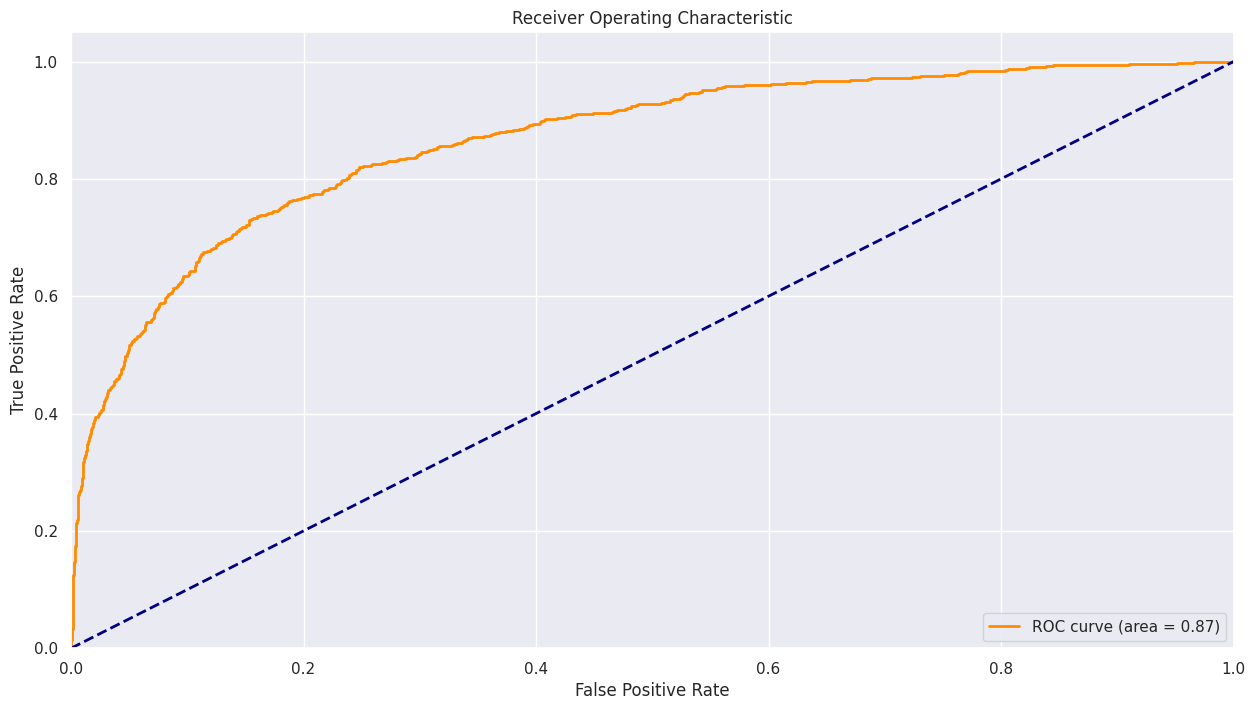

In [ ]:
# Convierte las etiquetas categóricas 'No' y 'Yes' en binarias (0 y 1)
label_binarizer = LabelBinarizer()
y_test_bin = label_binarizer.fit_transform(y_test_clas)

# Calcula la curva ROC y muestra la gráfica
fpr, tpr, _ = roc_curve(y_test_bin, model_log.predict_proba(X_test_clas)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Redes Neuronales

## RainTomorrow

In [ ]:
num_features = X.shape[1]

#Modelo de red neuronal
model_nn_cl = Sequential()
model_nn_cl.add(Dense(32, input_shape=(77,), activation='relu', input_dim=num_features))
model_nn_cl.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model_nn_cl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Entrenamiento del modelo
model_nn_cl.fit(X_train_clas, y_train_clas, epochs=10, batch_size=128, validation_data=(X_test_clas, y_test_clas))

Epoch 1/10
43/43 [==============================] - 2s 13ms/step - loss: 0.6811 - accuracy: 0.6236 - val_loss: 0.5149 - val_accuracy: 0.7566
Epoch 2/10
43/43 [==============================] - 0s 9ms/step - loss: 0.5328 - accuracy: 0.7337 - val_loss: 0.5040 - val_accuracy: 0.7553
Epoch 3/10
43/43 [==============================] - 0s 7ms/step - loss: 0.5015 - accuracy: 0.7549 - val_loss: 0.4918 - val_accuracy: 0.7650
Epoch 4/10
43/43 [==============================] - 0s 5ms/step - loss: 0.4862 - accuracy: 0.7645 - val_loss: 0.4814 - val_accuracy: 0.7709
Epoch 5/10
43/43 [==============================] - 0s 9ms/step - loss: 0.4764 - accuracy: 0.7707 - val_loss: 0.4780 - val_accuracy: 0.7723
Epoch 6/10
43/43 [==============================] - 0s 8ms/step - loss: 0.4680 - accuracy: 0.7767 - val_loss: 0.4766 - val_accuracy: 0.7706
Epoch 7/10
43/43 [==============================] - 0s 6ms/step - loss: 0.4604 - accuracy: 0.7817 - val_loss: 0.4739 - val_accuracy: 0.7726
Epoch 8/10
43/43 [=

In [ ]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results_cl = model_nn_cl.evaluate(X_test_clas, y_test_clas, verbose=0)

# Obtener e imprimir las métricas
loss_nn_cl, accuracy_nn_cl = evaluation_results_cl[0], evaluation_results_cl[1]
print(f"Loss: {loss_nn_cl}")
print(f"Accuracy: {accuracy_nn_cl}")

# Realizar predicciones en el conjunto de prueba
y_pred_nn_cl = model_nn_cl.predict(X_test_clas)

# Convertir las predicciones a clases binarias (0 o 1)
y_pred_nn_cl_binary = (y_pred_nn_cl > 0.5).astype(int)

# Calcular y mostrar otras métricas de clasificación
precision_nn_cl = precision_score(y_test_clas, y_pred_nn_cl_binary)
recall_nn_cl = recall_score(y_test_clas, y_pred_nn_cl_binary)
f1_nn_cl = f1_score(y_test_clas, y_pred_nn_cl_binary)
roc_auc_nn_cl = roc_auc_score(y_test_clas, y_pred_nn_cl)

print(f"Precision: {precision_nn_cl}")
print(f"Recall: {recall_nn_cl}")
print(f"F1 Score: {f1_nn_cl}")
print(f"ROC-AUC: {roc_auc_nn_cl}")

Loss: 0.4684714376926422
Accuracy: 0.7785904407501221
94/94 [==============================] - 0s 1ms/step
Precision: 0.521860465116279
Recall: 0.7868162692847125
F1 Score: 0.62751677852349
ROC-AUC: 0.8600243837600492


Probamos usando capas convolucionales:

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(77,), activation='relu', input_dim=num_features))
model.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(X_train_clas, y_train_clas, batch_size=128, epochs=10, verbose=1, validation_data=(X_test_clas, y_test_clas))
print("The model has successfully trained")

score = model.evaluate(X_test_clas, y_test_clas, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
43/43 [==============================] - 1s 7ms/step - loss: 0.6407 - accuracy: 0.6408 - val_loss: 0.5309 - val_accuracy: 0.7450
Epoch 2/10
43/43 [==============================] - 0s 4ms/step - loss: 0.5230 - accuracy: 0.7407 - val_loss: 0.5041 - val_accuracy: 0.7573
Epoch 3/10
43/43 [==============================] - 0s 4ms/step - loss: 0.4980 - accuracy: 0.7581 - val_loss: 0.4856 - val_accuracy: 0.7686
Epoch 4/10
43/43 [==============================] - 0s 3ms/step - loss: 0.4836 - accuracy: 0.7648 - val_loss: 0.5065 - val_accuracy: 0.7593
Epoch 5/10
43/43 [==============================] - 0s 3ms/step - loss: 0.4755 - accuracy: 0.7716 - val_loss: 0.4932 - val_accuracy: 0.7706
Epoch 6/10
43/43 [==============================] - 0s 3ms/step - loss: 0.4677 - accuracy: 0.7760 - val_loss: 0.4840 - val_accuracy: 0.7736
Epoch 7/10
43/43 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.7808 - val_loss: 0.4751 - val_accuracy: 0.7773
Epoch 8/10
43/43 [==

## RainfallTomorrow

In [ ]:
def r2_adjusted(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    n = K.cast(K.shape(y_true)[0], dtype='float32')
    p = K.cast(K.shape(y_true)[1], dtype='float32')
    r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1 + K.epsilon())
    return r2_adjusted

In [ ]:
model_nn_reg = Sequential()
model_nn_reg.add(Dense(32, input_shape=(77,), activation='relu', input_dim=num_features))
model_nn_reg.add(Dense(units=1))

model_nn_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=[[r2_adjusted]])

model_nn_reg.fit(X_train_reg, y_train_reg, epochs=10, batch_size=128, validation_data=(X_test_reg, y_test_reg))

Epoch 1/10
94/94 [==============================] - 1s 6ms/step - loss: 45.7366 - r2_adjusted: 0.0609 - val_loss: 59.6388 - val_r2_adjusted: 0.0946
Epoch 2/10
94/94 [==============================] - 0s 4ms/step - loss: 40.7136 - r2_adjusted: 0.1498 - val_loss: 56.2199 - val_r2_adjusted: 0.1265
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 38.7110 - r2_adjusted: 0.1834 - val_loss: 54.4693 - val_r2_adjusted: 0.1496
Epoch 4/10
94/94 [==============================] - 0s 4ms/step - loss: 37.4631 - r2_adjusted: 0.2228 - val_loss: 53.2465 - val_r2_adjusted: 0.1665
Epoch 5/10
94/94 [==============================] - 0s 4ms/step - loss: 36.5336 - r2_adjusted: 0.2257 - val_loss: 52.5762 - val_r2_adjusted: 0.1856
Epoch 6/10
94/94 [==============================] - 0s 4ms/step - loss: 35.8312 - r2_adjusted: 0.2273 - val_loss: 52.0345 - val_r2_adjusted: 0.1931
Epoch 7/10
94/94 [==============================] - 0s 4ms/step - loss: 35.2851 - r2_adjusted: 0.2544 - val_loss

In [ ]:
# Evaluación del modelo

y_pred_nn_reg = model_nn_reg.predict(X_test_reg)

r2_nn_reg = r2_score(y_test_reg, y_pred_nn_reg)
mse_nn_reg = mean_squared_error(y_test_reg, y_pred_nn_reg)
rmse_nn_reg = np.sqrt(mse_nn_reg)
mae_nn_reg = mean_absolute_error(y_test_reg, y_pred_nn_reg)
mape_nn_reg = mape(y_test_reg, y_pred_nn_reg)

# Mostrar los resultados
print(f"R2 Score: {r2_nn_reg}")
print(f"MSE: {mse_nn_reg}")
print(f"RMSE: {rmse_nn_reg}")
print(f"MAE: {mae_nn_reg}")
print(f"MAPE: {mape_nn_reg}%")

94/94 [==============================] - 0s 2ms/step
R2 Score: 0.2605462482305875
MSE: 50.694353743107676
RMSE: 7.119996751621989
MAE: 3.020270360859379
MAPE: 1710863827111.096%


Probamos usando capas convolucionales:

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(77,), activation='relu', input_dim=num_features))
model.add(Dense(1))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=[[r2_adjusted]])

hist = model.fit(X_train_reg, y_train_reg, batch_size=128, epochs=20, verbose=1, validation_data=(X_test_reg, y_test_reg))

Epoch 1/20
94/94 [==============================] - 1s 7ms/step - loss: 42.0740 - r2_adjusted: 0.0639 - val_loss: 55.9006 - val_r2_adjusted: 0.1981
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 37.6094 - r2_adjusted: 0.1586 - val_loss: 51.9123 - val_r2_adjusted: 0.2130
Epoch 3/20
94/94 [==============================] - 0s 3ms/step - loss: 38.4517 - r2_adjusted: 0.0870 - val_loss: 61.6608 - val_r2_adjusted: 0.0514
Epoch 4/20
94/94 [==============================] - 0s 4ms/step - loss: 37.3158 - r2_adjusted: 0.1759 - val_loss: 55.5422 - val_r2_adjusted: 0.1486
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 37.2753 - r2_adjusted: 0.0465 - val_loss: 52.0061 - val_r2_adjusted: 0.1065
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 37.8116 - r2_adjusted: 0.1346 - val_loss: 51.9624 - val_r2_adjusted: 0.1127
Epoch 7/20
94/94 [==============================] - 0s 3ms/step - loss: 37.9553 - r2_adjusted: 0.1553 - val_loss

# Optimización de Hiperparámetros

## Regresión Lineal

In [ ]:
model_gd

SGDRegressor(alpha=0.01, learning_rate='constant', max_iter=10000,
             random_state=42)

### Cross Validation

In [ ]:
# Realizamos validación cruzada
cv_scores = cross_val_score(model_gd, X_train_reg, y_train_reg, cv=5, scoring='r2')

# Imprimir los resultados de la validación cruzada
print("R2 Scores en cada fold:", cv_scores)
print("R2 Score promedio:", np.mean(cv_scores))
print("R2 Score SD:", cv_scores.std())

R2 Scores en cada fold: [-0.26651002 -1.09555471 -0.32200473 -0.09386589 -0.32400295]
R2 Score promedio: -0.42038765838418435
R2 Score SD: 0.34788347171546746


In [ ]:
# Crear el objeto KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada con KFold
cv_scores_kfold = cross_val_score(model_gd, X_train_reg, y_train_reg, cv=kfold, scoring='r2')

# Imprimir los resultados de la validación cruzada
print("R2 Scores en cada fold (KFold):", cv_scores_kfold)
print("R2 Score promedio (KFold):", np.mean(cv_scores_kfold))
print("R2 Score SD (KFold):", cv_scores_kfold.std())

R2 Scores en cada fold (KFold): [-0.17493383 -0.45693943 -0.36352616 -0.15872332  0.07899113]
R2 Score promedio (KFold): -0.21502632381579234
R2 Score SD (KFold): 0.18536334864279264


### Grid Search

In [ ]:
# Dividimos los datos de entrenamiento y validación
X_temp_reg, X_val_reg, y_temp_reg, y_val_reg = train_test_split(X_train_reg, y_train_reg, test_size=0.2, random_state=42)

# Definir los hiperparámetros a ajustar
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.5],
    'max_iter': [50, 100, 200],
}

# Definir la métrica de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(model_gd, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Realizar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_temp_reg, y_temp_reg)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model_sgd = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model_sgd.predict(X_val_reg)

In [ ]:
# Calcular y mostrar las métricas con el mejor modelo
r2_best = r2_score(y_val_reg, y_pred)
mse_best = mean_squared_error(y_val_reg, y_pred)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_val_reg, y_pred)
mape_best = mape(y_val_reg, y_pred)

print("Mejores hiperparámetros:", best_params)
print("R2 Score:", r2_best)
print("MSE:", mse_best)
print("RMSE:", rmse_best)
print("MAE:", mae_best)
print("MAPE:", mape_best)

Mejores hiperparámetros: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 50}
R2 Score: 0.23413768401024693
MSE: 46.9330035649704
RMSE: 6.850766640673903
MAE: 3.145864579889412
MAPE: 1111940293858.6333


Creamos el pipeline para MLOps

In [190]:
best_model_sgd

SGDRegressor(alpha=0.001, learning_rate='adaptive', max_iter=50,
             random_state=42)

In [ ]:
# Crea el pipeline
pipeline = Pipeline([('model', best_model_sgd)])

# Guardar el modelo utilizando joblib
joblib.dump(pipeline_gd, 'modelo_gradiente.joblib')

['modelo_gradiente.joblib']

## Regresión Logística

In [ ]:
model_log

LogisticRegression()

### Cross Validation

In [ ]:
# Realizar validación cruzada
cv_scores = cross_val_score(model_log, X_train_clas, y_train_clas, cv=5, scoring='accuracy')

# Imprimir los puntajes de cada fold
print("Puntajes de Validación Cruzada:", cv_scores)

# Imprimir el puntaje promedio y la desviación estándar
print("Puntaje Promedio:", cv_scores.mean())
print("Desviación Estándar:", cv_scores.std())

Puntajes de Validación Cruzada: [0.75       0.78571429 0.76831502 0.78021978 0.75549451]
Puntaje Promedio: 0.7679487179487179
Desviación Estándar: 0.01373748468322284


In [ ]:
# Crear un objeto StratifiedKFold con, por ejemplo, 5 folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada con StratifiedKFold
cv_scores = cross_val_score(model_log, X_train_clas, y_train_clas, cv=stratified_kfold, scoring='accuracy')

# Imprimir los puntajes de cada fold
print("Puntajes de Validación Cruzada:", cv_scores)

# Imprimir el puntaje promedio y la desviación estándar
print("Puntaje Promedio:", cv_scores.mean())
print("Desviación Estándar:", cv_scores.std())

Puntajes de Validación Cruzada: [0.78113553 0.78388278 0.753663   0.76465201 0.77197802]
Puntaje Promedio: 0.771062271062271
Desviación Estándar: 0.011049892402196606


### Grid Search

In [204]:
# Dividimos los datos de entrenamiento y validación
X_temp_clas, X_val_clas, y_temp_clas, y_val_clas = train_test_split(X_train_clas, y_train_clas, test_size=0.2, random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularización: l1 o l2
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inversa de la fuerza de regularización
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(model_log, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_temp_clas, y_temp_clas)

# Obtener los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)

# Obtener las predicciones en el conjunto de validación
y_val_pred = best_model.predict(X_val_clas)

# Calcular las métricas
accuracy = accuracy_score(y_val_clas, y_val_pred)
precision = precision_score(y_val_clas, y_val_pred)
recall = recall_score(y_val_clas, y_val_pred)
f1 = f1_score(y_val_clas, y_val_pred)
roc_auc = roc_auc_score(y_val_clas, y_val_pred)

# Imprimir las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)

Mejores hiperparámetros: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.8354114713216958
Precision: 0.7098591549295775
Recall: 0.46238532110091746
F1 Score: 0.5599999999999999
ROC-AUC: 0.7035193666224631


In [206]:
# Crear el pipeline con el modelo de clasificación
pipeline_clas = Pipeline([
    ('clasificador', best_model)
])

pipeline_clas.fit(X_temp_clas, y_temp_clas)

joblib.dump(pipeline_clas, 'modelo_clas.joblib')

['modelo_clas.joblib']

## NN Regresión

In [ ]:
model_nn_reg

### Optuna

In [ ]:
# Función de objetivo para regresión
def objective_reg(trial):
    # Obtener los valores sugeridos por Optuna
    units = trial.suggest_int('units', 16, 64)
    activation_hidden = trial.suggest_categorical('activation_hidden', ['relu', 'tanh', 'sigmoid'])
    activation_output = trial.suggest_categorical('activation_output', ['linear', 'relu'])

    # Crear un nuevo modelo con los hiperparámetros sugeridos
    nuevo_modelo_reg = Sequential()
    nuevo_modelo_reg.add(Dense(units, input_shape=(77,), activation=activation_hidden))
    nuevo_modelo_reg.add(Dense(units=1, activation=activation_output))

    # Compilar y entrenar el modelo
    nuevo_modelo_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    nuevo_modelo_reg.fit(X_train_reg, y_train_reg, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Realizar predicciones en los datos de prueba
    y_pred_reg = nuevo_modelo_reg.predict(X_test_reg).flatten()

    # Calcular las métricas
    r2_reg = r2_score(y_test_reg, y_pred_reg)
    mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
    rmse_reg = np.sqrt(mse_reg)
    mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
    mape_reg = np.mean(np.abs((y_test_reg - y_pred_reg) / y_test_reg)) * 100

    return mse_reg  # Optuna minimiza, así que usamos MSE como objetivo

# Crear el estudio de Optuna para regresión
study_reg = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_reg.optimize(objective_reg, n_trials=10)

# Obtener los mejores hiperparámetros para regresión
best_params_reg = study_reg.best_params

# Utilizar los mejores hiperparámetros para construir un nuevo modelo de regresión
mejor_modelo_reg = Sequential()
mejor_modelo_reg.add(Dense(best_params_reg['units'], input_shape=(77,), activation=best_params_reg['activation_hidden']))
mejor_modelo_reg.add(Dense(units=1, activation=best_params_reg['activation_output']))

# Compilar y entrenar el modelo final
mejor_modelo_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
mejor_modelo_reg.fit(X_train_reg, y_train_reg, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Realizar predicciones en los datos de prueba
y_pred_reg_optuna = mejor_modelo_reg.predict(X_test_reg).flatten()

# Calcular las métricas finales
r2_final_reg = r2_score(y_test_reg, y_pred_reg_optuna)
mse_final_reg = mean_squared_error(y_test_reg, y_pred_reg_optuna)
rmse_final_reg = np.sqrt(mse_final_reg)
mae_final_reg = mean_absolute_error(y_test_reg, y_pred_reg_optuna)
mape_final_reg = mape(y_test_reg, y_pred_reg_optuna)

# Imprimir las métricas finales
print("\nScores finales del modelo de regresión:")
print(f"R2 Score: {r2_final_reg}")
print(f"MSE: {mse_final_reg}")
print(f"RMSE: {rmse_final_reg}")
print(f"MAE: {mae_final_reg}")
print(f"MAPE: {mape_final_reg}%")

[I 2023-12-07 22:36:23,725] A new study created in memory with name: no-name-f6c7a80c-25c5-4139-af7e-999c7476433e


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:36:34,887] Trial 0 finished with value: 49.57116296946266 and parameters: {'units': 34, 'activation_hidden': 'relu', 'activation_output': 'linear'}. Best is trial 0 with value: 49.57116296946266.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:36:41,921] Trial 1 finished with value: 49.536865476500004 and parameters: {'units': 18, 'activation_hidden': 'relu', 'activation_output': 'relu'}. Best is trial 1 with value: 49.536865476500004.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:36:50,726] Trial 2 finished with value: 48.24973226547638 and parameters: {'units': 56, 'activation_hidden': 'relu', 'activation_output': 'relu'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:37:01,947] Trial 3 finished with value: 50.356495622858695 and parameters: {'units': 37, 'activation_hidden': 'tanh', 'activation_output': 'relu'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:37:10,155] Trial 4 finished with value: 49.247284171289216 and parameters: {'units': 38, 'activation_hidden': 'relu', 'activation_output': 'linear'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:37:17,834] Trial 5 finished with value: 54.39260370430469 and parameters: {'units': 45, 'activation_hidden': 'sigmoid', 'activation_output': 'linear'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:37:29,201] Trial 6 finished with value: 50.89267728194494 and parameters: {'units': 30, 'activation_hidden': 'tanh', 'activation_output': 'relu'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:37:37,882] Trial 7 finished with value: 49.53671923147806 and parameters: {'units': 17, 'activation_hidden': 'relu', 'activation_output': 'relu'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:37:49,126] Trial 8 finished with value: 53.098916545107244 and parameters: {'units': 42, 'activation_hidden': 'tanh', 'activation_output': 'linear'}. Best is trial 2 with value: 48.24973226547638.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:37:56,752] Trial 9 finished with value: 48.04429011238851 and parameters: {'units': 45, 'activation_hidden': 'relu', 'activation_output': 'relu'}. Best is trial 9 with value: 48.04429011238851.


94/94 [==============================] - 0s 1ms/step

Scores finales del modelo de regresión:
R2 Score: 0.2954329387800413
MSE: 48.302644691110274
RMSE: 6.950010409424598
MAE: 2.4748771070185653
MAPE: 329595368187.91516%


In [ ]:
best_params_reg

{'units': 45, 'activation_hidden': 'relu', 'activation_output': 'relu'}

## NN Clasificación

In [ ]:
model_nn_cl

### Optuna

In [ ]:
# Función de objetivo para clasificación
def objective_clas(trial):
    # Obtener los valores sugeridos por Optuna
    units = trial.suggest_int('units', 16, 64)
    activation_hidden = trial.suggest_categorical('activation_hidden', ['relu', 'tanh', 'sigmoid'])
    activation_output = trial.suggest_categorical('activation_output', ['sigmoid', 'softmax'])

    # Crear un nuevo modelo con los hiperparámetros sugeridos
    nuevo_modelo_clas = Sequential()
    nuevo_modelo_clas.add(Dense(units, input_shape=(77,), activation=activation_hidden))
    nuevo_modelo_clas.add(Dense(units=1, activation=activation_output))

    # Compilar y entrenar el modelo
    nuevo_modelo_clas.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    nuevo_modelo_clas.fit(X_train_clas, y_train_clas, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    # Realizar predicciones en los datos de prueba
    y_prob_clas = nuevo_modelo_clas.predict(X_test_clas)
    y_pred_clas = (y_prob_clas > 0.5).astype(int)

    # Calcular las métricas
    accuracy_clas = accuracy_score(y_test_clas, y_pred_clas)
    precision_clas = precision_score(y_test_clas, y_pred_clas)
    recall_clas = recall_score(y_test_clas, y_pred_clas)
    f1_clas = f1_score(y_test_clas, y_pred_clas)

    return 1.0 - accuracy_clas  # Optuna minimiza, así que usamos 1 - accuracy

# Crear el estudio de Optuna para clasificación
study_clas = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_clas.optimize(objective_clas, n_trials=10)

# Obtener los mejores hiperparámetros para clasificación
best_params_clas = study_clas.best_params

# Utilizar los mejores hiperparámetros para construir un nuevo modelo de clasificación
mejor_modelo_clas = Sequential()
mejor_modelo_clas.add(Dense(best_params_clas['units'], input_shape=(77,), activation=best_params_clas['activation_hidden']))
mejor_modelo_clas.add(Dense(units=1, activation=best_params_clas['activation_output']))

# Compilar y entrenar el modelo final
mejor_modelo_clas.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mejor_modelo_clas.fit(X_train_clas, y_train_clas, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Realizar predicciones en los datos de prueba
y_prob_clas_optuna = mejor_modelo_clas.predict(X_test_clas)
y_pred_clas_optuna = (y_prob_clas_optuna > 0.5).astype(int)

# Calcular las métricas finales
accuracy_final = accuracy_score(y_test_clas, y_pred_clas_optuna)
precision_final = precision_score(y_test_clas, y_pred_clas_optuna)
recall_final = recall_score(y_test_clas, y_pred_clas_optuna)
f1_final = f1_score(y_test_clas, y_pred_clas_optuna)

# Imprimir las métricas finales
print("\nScores finales del modelo de clasificación:")
print(f"Accuracy: {accuracy_final}")
print(f"Precisión: {precision_final}")
print(f"Recall: {recall_final}")
print(f"F1 Score: {f1_final}")

[I 2023-12-07 22:38:07,879] A new study created in memory with name: no-name-0fd15bca-ee99-4b0d-9e21-6dc19c44c813


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:13,929] Trial 0 finished with value: 0.17686170212765961 and parameters: {'units': 34, 'activation_hidden': 'relu', 'activation_output': 'sigmoid'}. Best is trial 0 with value: 0.17686170212765961.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:38:20,125] Trial 1 finished with value: 0.7629654255319149 and parameters: {'units': 18, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.17686170212765961.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:25,419] Trial 2 finished with value: 0.7629654255319149 and parameters: {'units': 56, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.17686170212765961.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:38:31,654] Trial 3 finished with value: 0.7629654255319149 and parameters: {'units': 37, 'activation_hidden': 'tanh', 'activation_output': 'softmax'}. Best is trial 0 with value: 0.17686170212765961.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:37,114] Trial 4 finished with value: 0.1748670212765957 and parameters: {'units': 38, 'activation_hidden': 'relu', 'activation_output': 'sigmoid'}. Best is trial 4 with value: 0.1748670212765957.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:43,156] Trial 5 finished with value: 0.17420212765957444 and parameters: {'units': 45, 'activation_hidden': 'sigmoid', 'activation_output': 'sigmoid'}. Best is trial 5 with value: 0.17420212765957444.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:38:47,608] Trial 6 finished with value: 0.7629654255319149 and parameters: {'units': 30, 'activation_hidden': 'tanh', 'activation_output': 'softmax'}. Best is trial 5 with value: 0.17420212765957444.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:53,951] Trial 7 finished with value: 0.7629654255319149 and parameters: {'units': 17, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 5 with value: 0.17420212765957444.


94/94 [==============================] - 0s 1ms/step


[I 2023-12-07 22:38:58,055] Trial 8 finished with value: 0.17220744680851063 and parameters: {'units': 42, 'activation_hidden': 'tanh', 'activation_output': 'sigmoid'}. Best is trial 8 with value: 0.17220744680851063.


94/94 [==============================] - 0s 2ms/step


[I 2023-12-07 22:39:02,263] Trial 9 finished with value: 0.7629654255319149 and parameters: {'units': 45, 'activation_hidden': 'relu', 'activation_output': 'softmax'}. Best is trial 8 with value: 0.17220744680851063.


94/94 [==============================] - 0s 1ms/step

Scores finales del modelo de clasificación:
Accuracy: 0.8284574468085106
Precisión: 0.6280884265279584
Recall: 0.6774193548387096
F1 Score: 0.6518218623481781


In [ ]:
best_params_clas

{'units': 42, 'activation_hidden': 'tanh', 'activation_output': 'sigmoid'}

# SHAP

## Regresión Lineal

In [ ]:
# Usamos SHAP para explicar el modelo de regresión lineal
explainer = shap.explainers.Linear(model_rl, X_shap_reg)
shap_values = explainer(X_shap_reg)

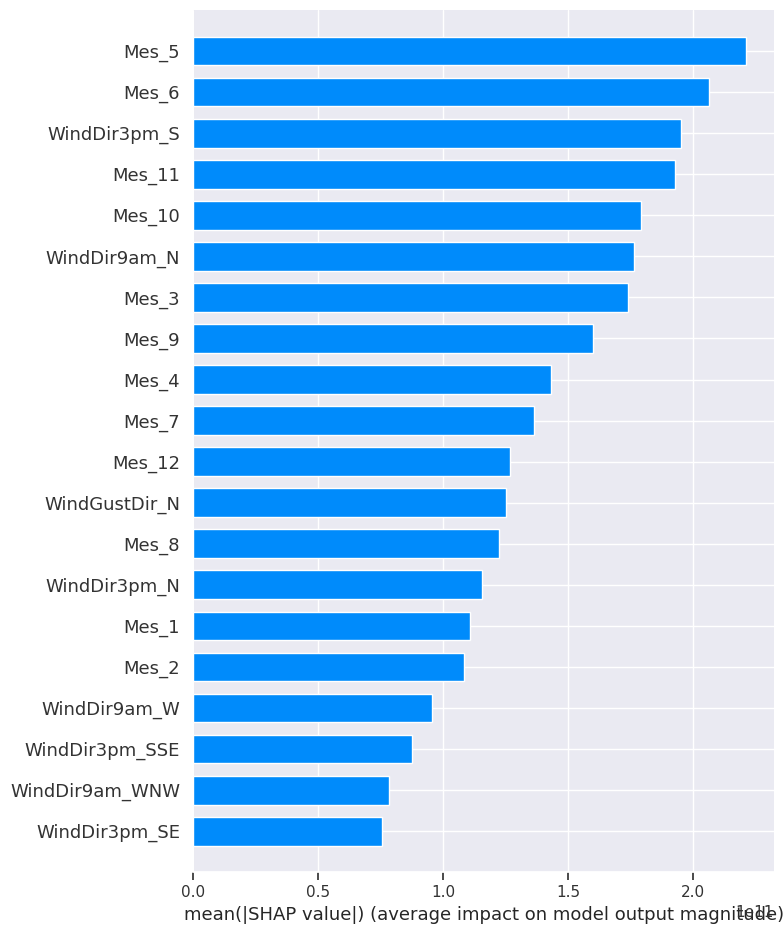

In [ ]:
# Bar chart of mean importance
shap.summary_plot(shap_values, X_shap_reg, plot_type="bar")

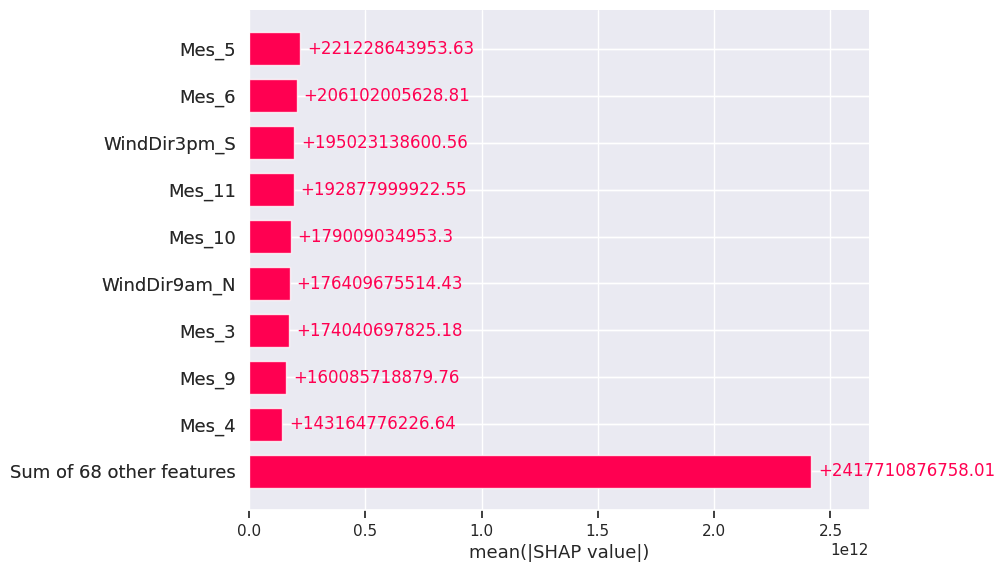

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

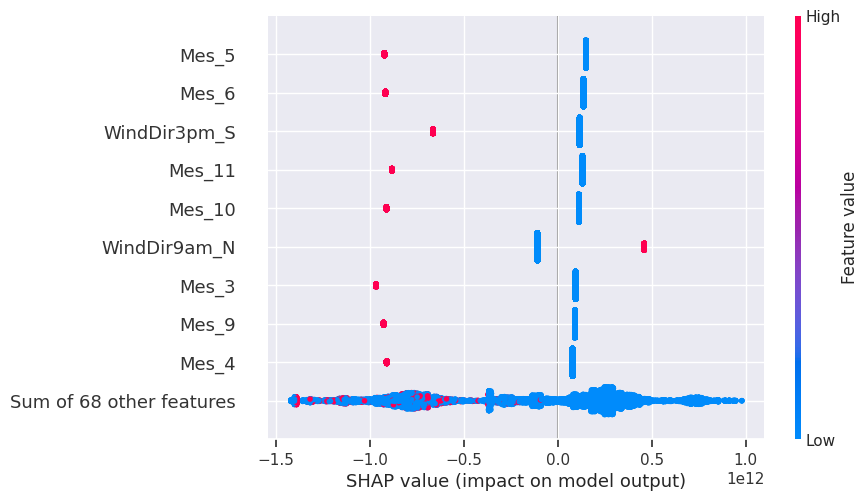

In [ ]:
# Summarize the effect of all the features
shap.plots.beeswarm(shap_values)

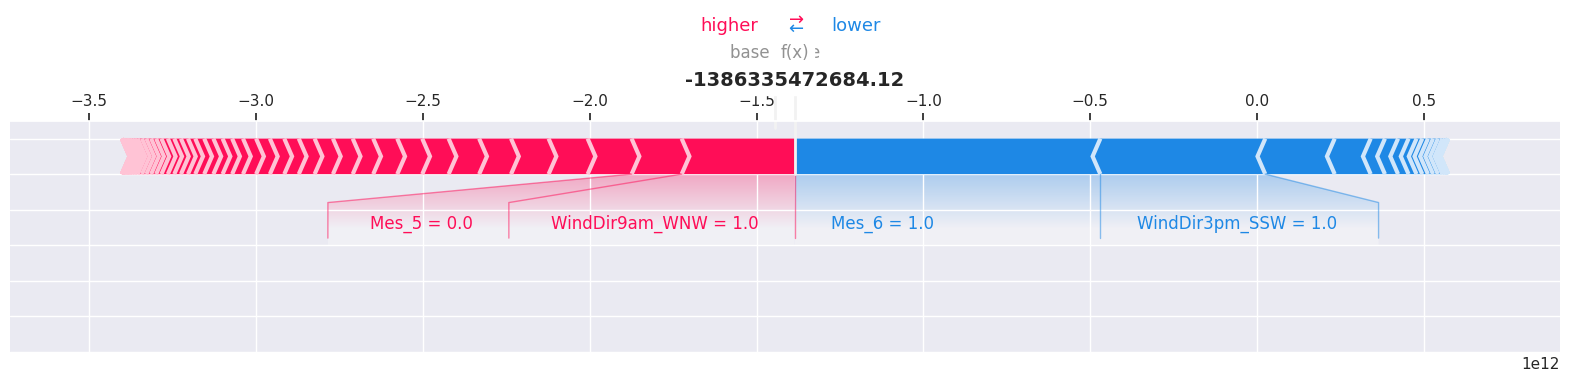

In [ ]:
# Explain the first review’s sentiment prediction
ind = 0
shap.plots.force(shap_values[ind], matplotlib=True)

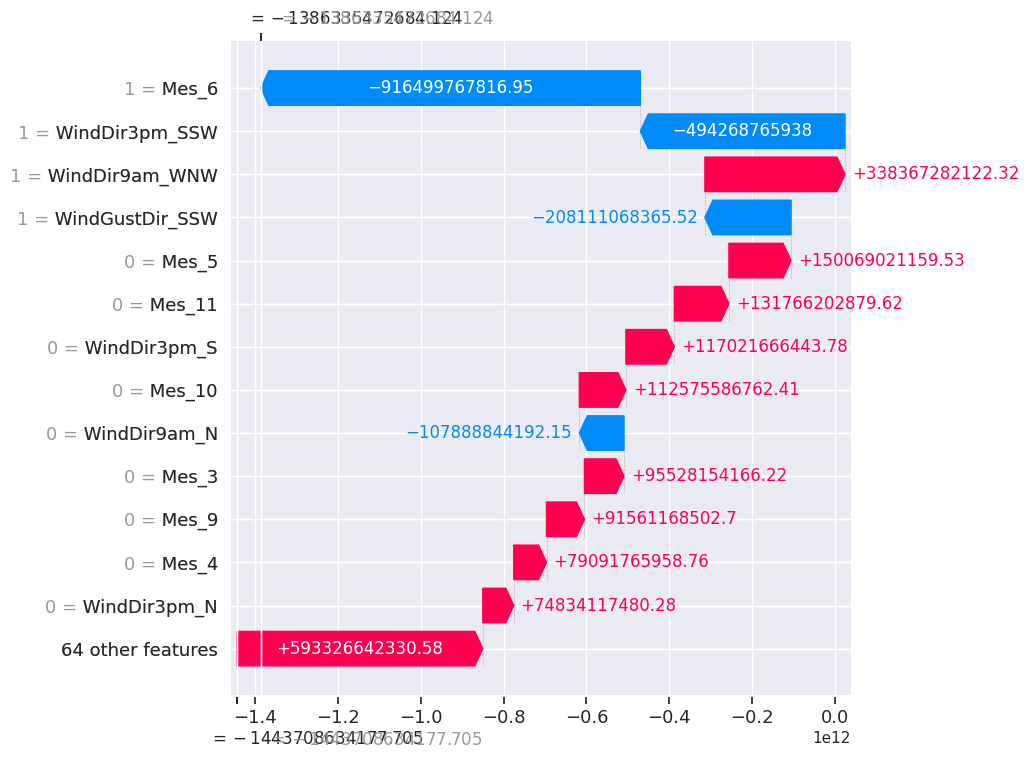

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[ind], max_display=14)

## Clasificación

In [ ]:
# Usamos SHAP para explicar el modelo de clasificación
explainer = shap.explainers.Linear(model_log, X_shap_clas)
shap_values = explainer(X_shap_clas)

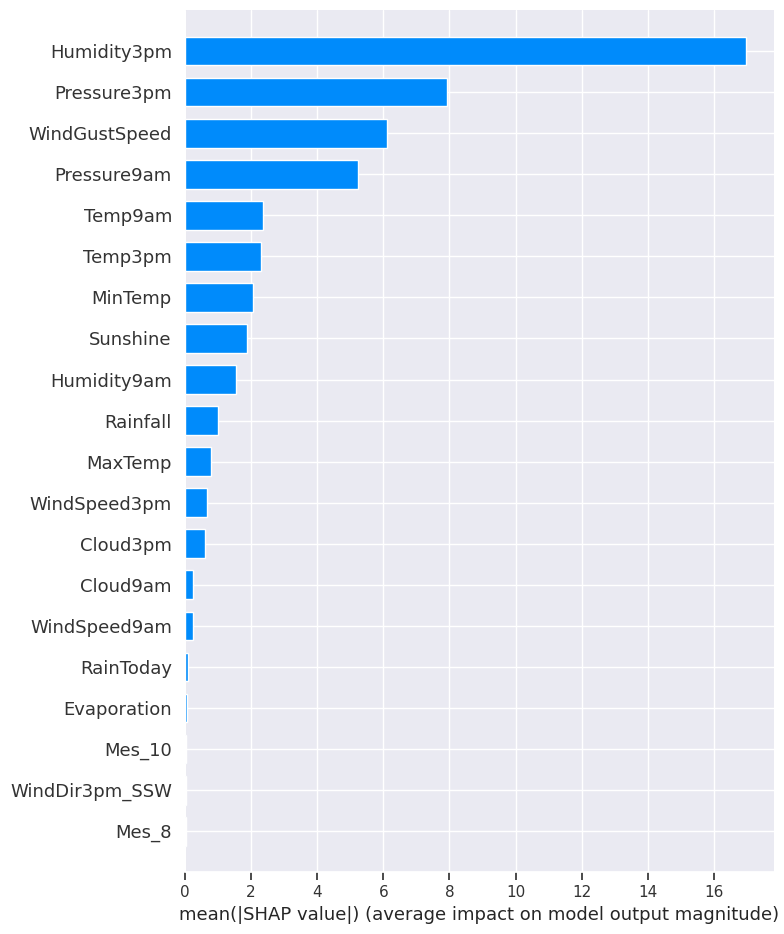

In [ ]:
# Bar chart of mean importance
shap.summary_plot(shap_values, X_shap_clas, plot_type="bar")

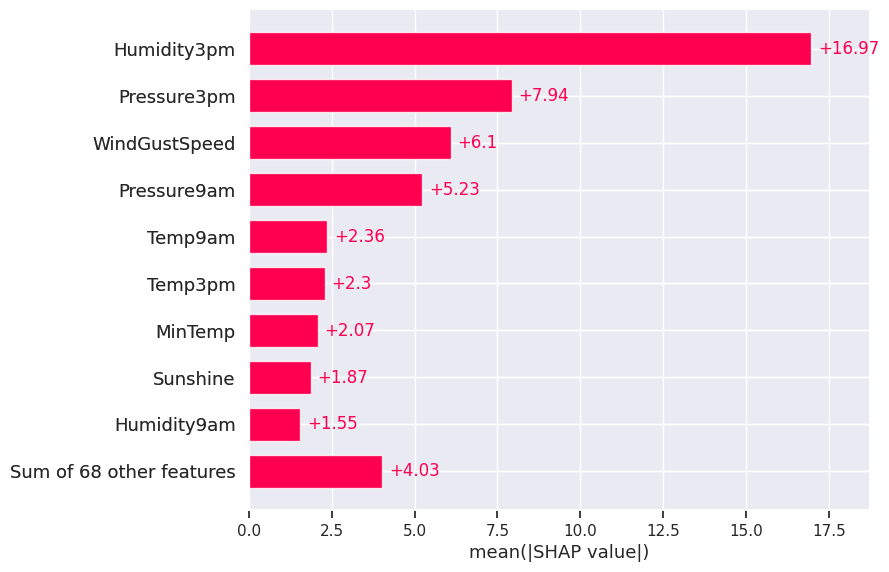

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

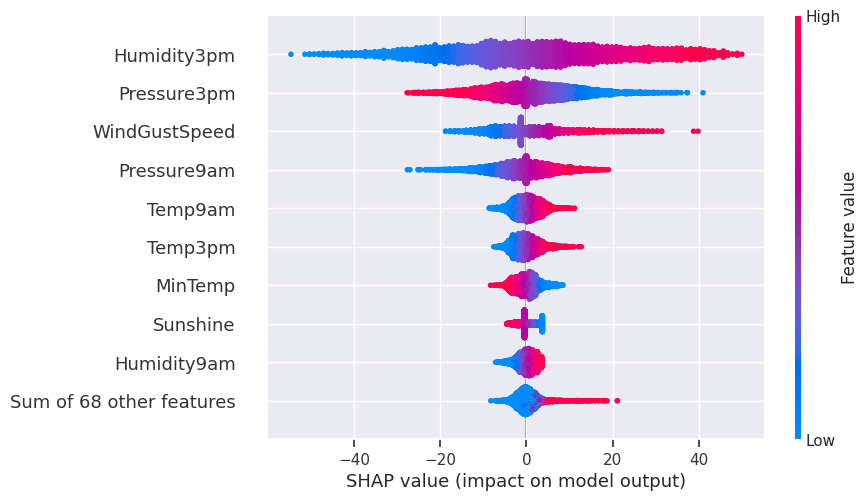

In [ ]:
# Summarize the effect of all the features
shap.plots.beeswarm(shap_values)

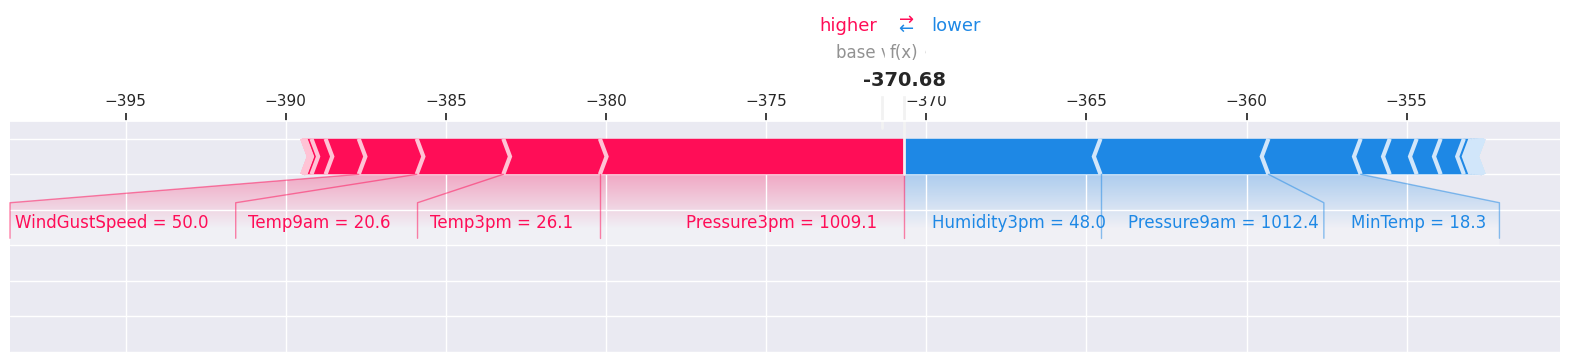

In [ ]:
# Explain the first review’s sentiment prediction
ind = 0
shap.plots.force(shap_values[ind], matplotlib=True)

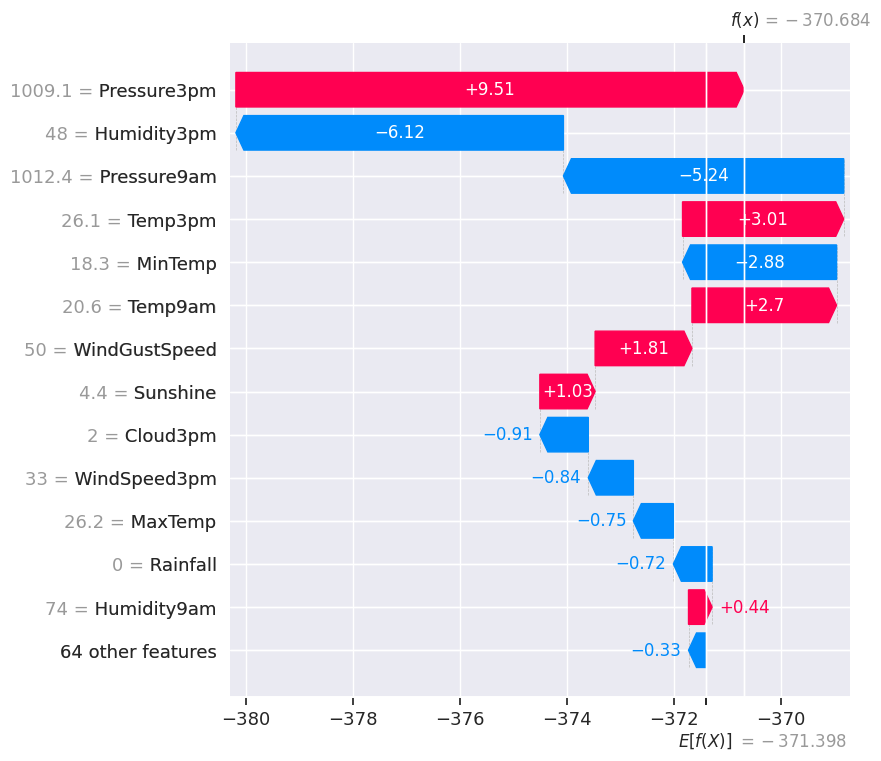

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[ind], max_display=14)

## NN

In [ ]:
def f(X):
    return model_rl.predict(X).flatten()

### Regresión

In [ ]:
explainer = shap.KernelExplainer(f, X_shap_reg.iloc[:77, :])
ex_shap_values = explainer.shap_values(X_shap_reg.iloc[299, :], nsamples=500)

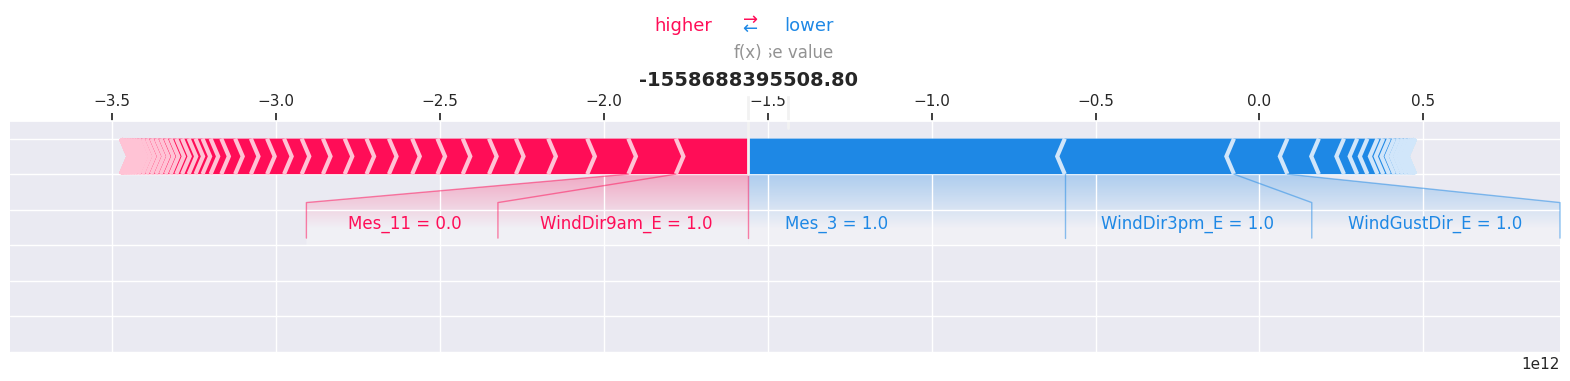

In [ ]:
shap.force_plot(explainer.expected_value, ex_shap_values, X_shap_reg.iloc[299, :], matplotlib=True)

### Clasificación

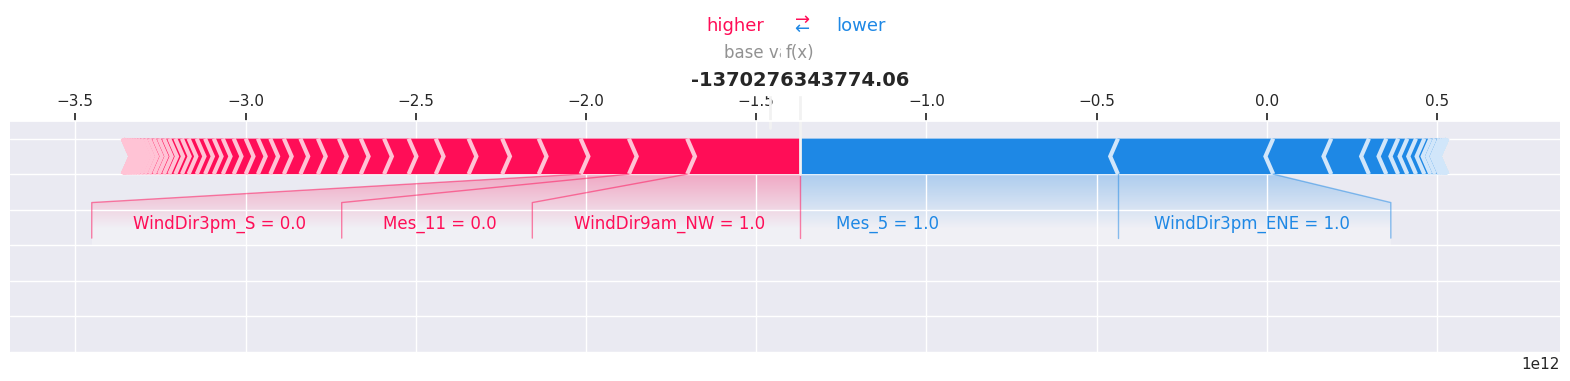

In [ ]:
explainer = shap.KernelExplainer(f, X_shap_clas.iloc[:77, :])
shap_values = explainer.shap_values(X_shap_clas.iloc[299, :], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_shap_clas.iloc[299, :], matplotlib=True)